/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-18 19:23:27,523 - qm - INFO     - Starting session: 99382023-dbb4-4c48-b90b-a0bbaa134676

 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
                 ┌─────────────────────────────┐     
        q_0 -> 0 ┤0                            ├──■──
                 │  custom_kron(rx,ident)_gate │┌─┴─┐
        q_1 -> 1 ┤1                            ├┤ X ├
                 └─────────────────────────────┘└───┘
  ancilla_0 -> 2 ────────────────────────────────────
                                                     
  ancilla_1 -> 3 ────────────────────────────────────
                                                     
  ancilla_2 -> 4 ────────────────────────────────────
                                                     
  ancilla_3 -> 5 ────────────────────────────────────
                    

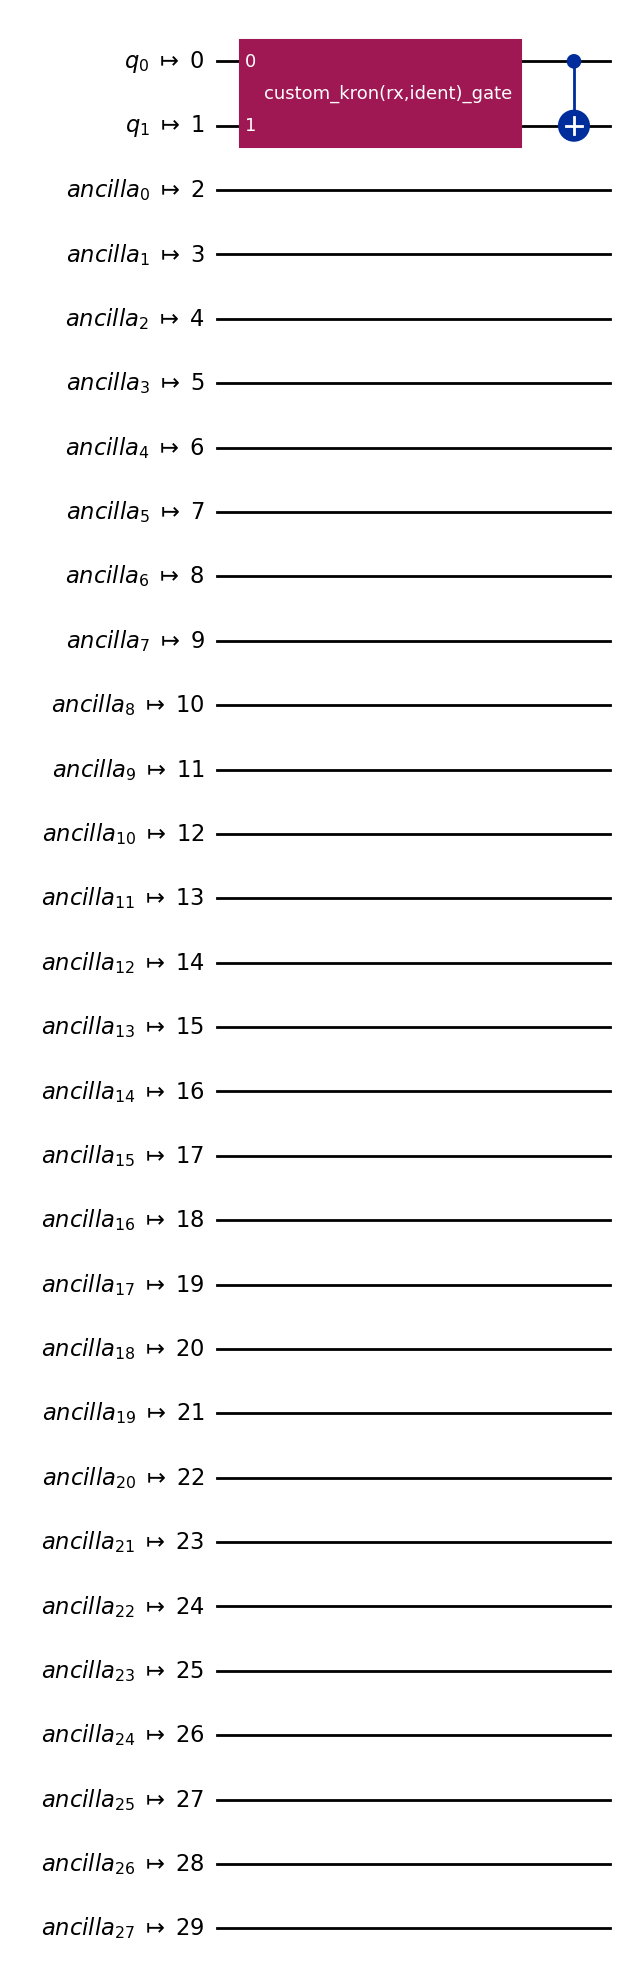

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from spillover_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context, phi, gamma
)
from quantumenvironment import QuantumEnvironmentV2
from context_aware_quantum_environment import ContextAwareQuantumEnvironment, ContextAwareQuantumEnvironmentV2
from hyperparameter_optimization import HyperparameterOptimizer
from gymnasium.wrappers import RescaleAction, ClipAction

from spillover_noise_quantum_environment import SpilloverNoiseQuantumEnvironment

from hpo_training_config import (
    DirectoryPaths,
    HardwarePenaltyWeights,
    HPOConfig,
    TotalUpdates,
    HardwareRuntime,
    TrainingDetails,
    TrainingConfig,
    TrainFunctionSettings,
)

import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)
circuit_context.draw('mpl')

In [2]:
q_env = SpilloverNoiseQuantumEnvironment(gate_q_env_config, circuit_context, (phi, gamma))
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

q_env.unwrapped.backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

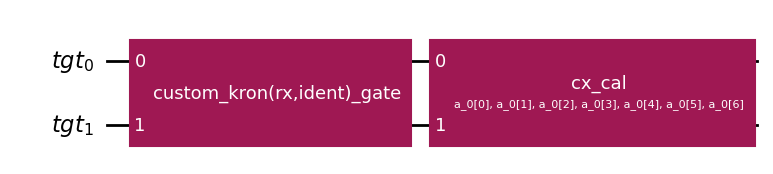

In [3]:
q_env.unwrapped.circuits[0].draw("mpl")

In [4]:
from helper_functions import load_from_yaml_file
agent_config = load_from_yaml_file('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')

In [5]:
path_agent_config = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml'
path_hpo_config = '/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/gate_level_abstraction/spillover_noise_use_case/noise_hpo_config.yaml'
save_results_path = "hpo_results"

experimental_penalty_weights = HardwarePenaltyWeights(
    shots_penalty=0.01,
    missed_fidelity_penalty=1e4,
    fidelity_reward=2*1e4,
)

directory_paths = DirectoryPaths(
    agent_config_path=path_agent_config,
    hpo_config_path=path_hpo_config,
    save_results_path=save_results_path,
)

hpo_config = HPOConfig(
    q_env=q_env,
    num_trials=2,
    hardware_penalty_weights=experimental_penalty_weights,
    hpo_paths=directory_paths,
)

In [6]:
total_updates = TotalUpdates(10)
# hardware_runtime = HardwareRuntime(300)
training_details = TrainingDetails(training_constraint=total_updates, target_fidelities=[0.999, 0.9999], lookback_window=10, anneal_learning_rate=True, std_actions_eps=1e-2)
training_config = TrainingConfig(training_mode="spillover_noise_use_case", training_details=training_details)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=True,
    clear_history=True
)

In [7]:
# Define your callback function
def print_summary_callback(trial_data, **kwargs):
    print(f"Trial number: {trial_data['trial_number']}")
    print(f"Max Fidelity: {max(trial_data['training_results']['fidelity_history'])}")
    print(f"Hardware Runtime: {round(sum(trial_data['training_results']['hardware_runtime']), 2)} seconds")
    print(f"Custom cost value: {round(trial_data['custom_cost_value'], 2)}")
    print(f"Simulation runtime: {round(trial_data['simulation runtime'], 2)} seconds")
    for key, value in kwargs.items():
        print(f"{key}: {value}")

In [8]:
hpo_engine = HyperparameterOptimizer(
    hpo_config=hpo_config,
    callback=print_summary_callback,
)

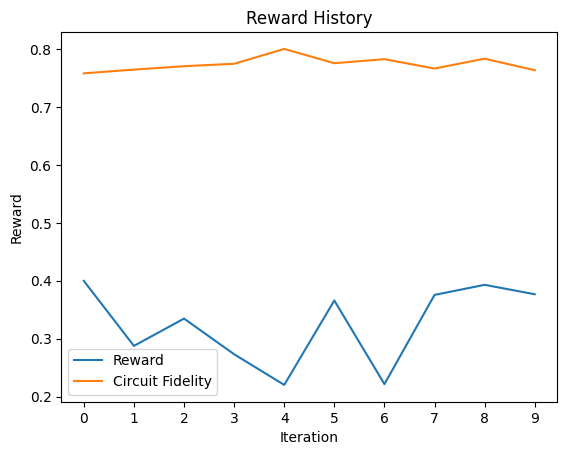

100%|██████████| 10/10 [01:47<00:00, 10.76s/it]

2024-06-18 19:26:10 INFO Target fidelity 0.999 not achieved within TotalUpdates(total_updates=10).
2024-06-18 19:26:10 INFO Target fidelity 0.9999 not achieved within TotalUpdates(total_updates=10).



[I 2024-06-18 19:26:10,369] Trial 1 finished with value: 17803.85847958621 and parameters: {'MINIBATCH_SIZE': 16, 'NUM_MINIBATCHES': 10, 'N_SHOTS': 15, 'SAMPLE_PAULIS': 94}. Best is trial 0 with value: 13342.68189371428.


Trial number: 1
Max Fidelity: 0.8004570760206894
Hardware Runtime: 3.04 seconds
Custom cost value: 17803.86
Simulation runtime: 107.6 seconds
2024-06-18 19:26:10 INFO All trials have been saved to hpo_results/SpilloverNoise_phi-0.25pi_gamma-0.01_gate_calibration_cx-gate_physical_qubits_0-1_TotalUpdates(total_updates=10)_custom-cost-value-13342.681894_timestamp_18-06-2024_19-26-10.pickle.gzip.
2024-06-18 19:26:10 INFO ---------------- FINISHED HPO ----------------
2024-06-18 19:26:10 INFO HPO completed in 2.62 minutes.
2024-06-18 19:26:10 INFO Best trial:
2024-06-18 19:26:10 INFO -------------------------
2024-06-18 19:26:10 INFO   Custom Cost Value: 13342.68189371428
2024-06-18 19:26:10 INFO   Hyperparameters: 
2024-06-18 19:26:10 INFO     MINIBATCH_SIZE: 10
2024-06-18 19:26:10 INFO     NUM_MINIBATCHES: 8
2024-06-18 19:26:10 INFO     N_SHOTS: 58
2024-06-18 19:26:10 INFO     SAMPLE_PAULIS: 31
2024-06-18 19:26:10 INFO The best action vector: [0. 0. 0. 0. 0. 0. 0.]


In [9]:
best_trial = hpo_engine.optimize_hyperparameters(
    training_config=training_config, train_function_settings=train_function_settings
)